In [1]:
import os
import sys

%run constants.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum

from src.data.paths import raw_data_path

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# Problem description
We are provided with daily historical sales data (in a day by day format) and the task is to forecast the total amount of products sold in every shop for the test set, which is dated to the next month.

Evaluation will be done with RMSE. One thing caught my attention: True target values are clipped into `[0,20]`.

# But first, some conventions

- First it's worth noting that all data is under `../.data`. 
- We will use a Makefile to describe the execution steps and dependency graph of the whole analysis. The goal is to be able to run `make final-submission` to generate the final submission from scratch.
- Notebooks are only used for exploration and documentation. The final result is coded separately (inside `../src`) from the experience gathered through notebooks.

In [2]:
import zipfile
with zipfile.ZipFile(os.path.join(RAW_DATA_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    item_categories = pd.read_csv(datasets_file.open('item_categories.csv'))
    items = pd.read_csv(datasets_file.open('items.csv'))
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))
    sample_submission = pd.read_csv(datasets_file.open('sample_submission.csv'))
    shops = pd.read_csv(datasets_file.open('shops.csv'))
    test_set = pd.read_csv(datasets_file.open('test.csv'))

# Training/test sets

In [3]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test_set.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [6]:
test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


First thing I noticed by looking at the descriptions: shop ids below 2 were dropped on the test set, along with item ids below 30. Let's filter those lines out from the train set right away.

In [6]:
sales_train_filtered = sales_train[~((sales_train['shop_id'] < 2) | (sales_train['item_id'] < 30) | (sales_train['item_id'] > 22167))]

In [7]:
sales_train_filtered.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.920132e+06,2.920132e+06,2.920132e+06,2.920132e+06,2.920132e+06
mean,1.464506e+01,3.317534e+01,1.019529e+04,8.926938e+02,1.243099e+00
std,9.391895e+00,1.609398e+01,6.324212e+03,1.731929e+03,2.625509e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.475000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.327000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568300e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,3.079800e+05,2.169000e+03


That reduces a bit the data set, which should be good for us.

The next thing I noticed is the train data has prices for each item sold, while test doesn't. This means we'll probably have to rely on previous month's prices instead of the current ones.

About the clipping on the true targets range: let's see if this also happens on the train set.

In [8]:
# notice `date_block_num` is actually related to the month
sales_train_by_month = sales_train_filtered.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_train_by_month.rename(columns={'item_cnt_day': 'item_cnt'}, inplace=True)
sales_train_by_month['item_cnt'].describe()

count    1.600855e+06
mean     2.267546e+00
std      8.668920e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt, dtype: float64

Nope :) Just have to remember to clip the train target. Also interesting to see that the 75 percentile is 2 while the maximum is 2,253. As the distribution is so skewed to 0, let's try plotting it in a log scale and se what happens:

<AxesSubplot:>

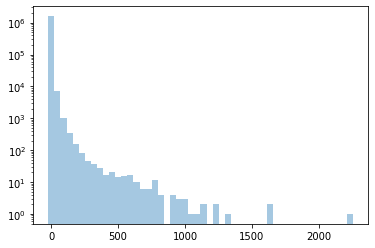

In [10]:
sns.distplot(sales_train_by_month['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Results near zero are orders of magnitude larger than the rest, but let's keep in mind this is before the clipping. Let's clip it and see how this looks like

In [9]:
sales_train_by_month_clipped = sales_train_by_month.copy()
sales_train_by_month_clipped['item_cnt'] = np.clip(sales_train_by_month_clipped['item_cnt'], 0, 20)
sales_train_by_month_clipped.describe()

,date_block_num,shop_id,item_id,item_cnt
count,1.600855e+06,1.600855e+06,1.600855e+06,1.600855e+06
mean,1.473702e+01,3.296987e+01,1.067828e+04,2.022226e+00
std,9.513026e+00,1.641684e+01,6.238855e+03,2.577318e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00
25%,6.000000e+00,2.100000e+01,5.043000e+03,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049200e+04,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.605900e+04,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,2.000000e+01


<AxesSubplot:>

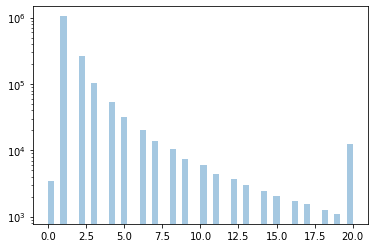

In [12]:
sns.distplot(sales_train_by_month_clipped['item_cnt'].values, hist_kws={'log':True}, kde=False, norm_hist=False)

Still not pretty, decaying orders of magnitude until it reaches 20. Good to keep that in mind (maybe we're better off predicting only the extremities well?). Either way, this logic will be available as a script.

# Train/Test consistency

We need to generate the train set from a list of historical events. The problem with that is we may end up with a train set that doesn't come from the same probability distribution as the test set samples.

To test this, let's look at the distribution of item id + shop id pairs on each data set.

<AxesSubplot:xlabel='shop_id'>

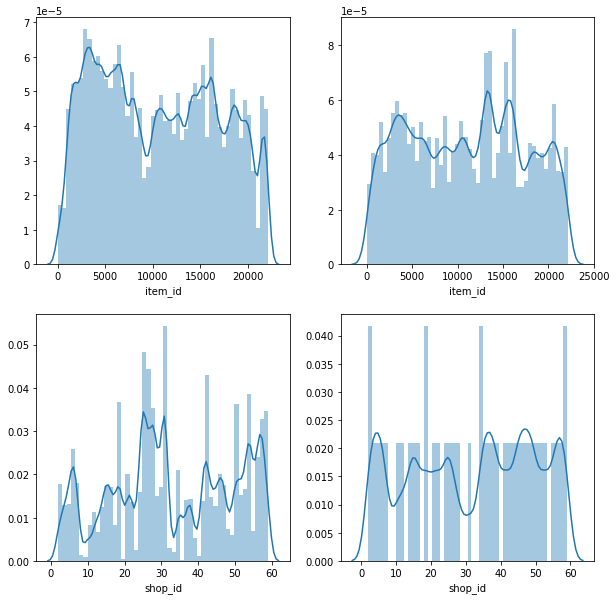

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(sales_train_by_month_clipped['item_id'], ax=axes[0][0])
sns.distplot(test_set['item_id'], ax=axes[0][1])
sns.distplot(sales_train_by_month_clipped['shop_id'], ax=axes[1][0])
sns.distplot(test_set['shop_id'], ax=axes[1][1])

Pretty different, specially the shops. Let's look at the last month of the train data, since time might explain this effect.

<AxesSubplot:xlabel='shop_id'>

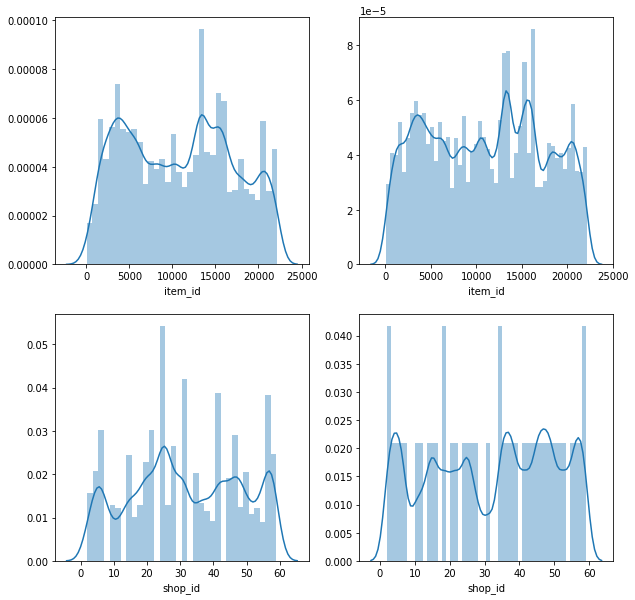

In [15]:
sales_train_last_month = sales_train_by_month_clipped[sales_train_by_month_clipped['date_block_num'] == sales_train_by_month_clipped['date_block_num'].max()]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(sales_train_last_month['item_id'], ax=axes[0][0])
sns.distplot(test_set['item_id'], ax=axes[0][1])
sns.distplot(sales_train_last_month['shop_id'], ax=axes[1][0])
sns.distplot(test_set['shop_id'], ax=axes[1][1])

It's obvious shop id on the test set was generated artificially, but we can see it respects the fact that some shops were closed.

Let's check how much these two sets intersect:

In [62]:
pd.merge(sales_train_last_month, test_set, on=['item_id', 'shop_id'])['ID'].size / test_set['ID'].size

0.13389355742296918

In [22]:
pd.merge(sales_train_last_month, test_set, on=['item_id', 'shop_id'])['item_id'].size / sales_train_last_month['item_id'].size

0.9095810472233675

Almost all of the samples on the last month are present on the test set, but only 10% of the test set is present on the last month. This probably means that 90% of the test set are pairs that will not be sold.

In [31]:
ids_on_train = sales_train[['item_id', 'shop_id']].drop_duplicates()
pd.merge(ids_on_train, test_set, on=['item_id', 'shop_id'])['item_id'].size / ids_on_train['item_id'].size

0.2626684648829116

If we consider any pair that appeared on the train set as valid we get 74% of fake data.

# Benchmark submission

The sample submission uses the counts for the last month, and imputs the missing values with zero.

In [24]:
solution_benchmark = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id']).fillna(0)
solution_benchmark.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,4.418487,31.642857,11019.398627,0.255649,107099.500000
std,11.237777,17.561933,6252.644590,1.089856,61834.358168
min,0.000000,2.000000,30.000000,0.000000,0.000000
25%,0.000000,16.000000,5381.500000,0.000000,53549.750000
50%,0.000000,34.500000,11203.000000,0.000000,107099.500000
75%,0.000000,47.000000,16071.500000,0.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [25]:
solution_benchmark[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-submission.csv'), index=False)

In [24]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-submission.csv -m 'benchmark reproduction' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 2.14M/2.14M [00:06<00:00, 336kB/s] 


The score is as expected: 1.16777. Let's try and beat that with some simple heuristics. Instead of replacing NaNs with zeros, let's replace them with the mean of the other items counts.

In [25]:
benchmark_mean_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_mean_imputation.fillna(benchmark_mean_imputation['item_cnt'].mean(), inplace=True)
benchmark_mean_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,6.072183,31.642857,11019.398627,1.909344,107099.500000
std,10.587572,17.561933,6252.644590,0.874654,61834.358168
min,1.909344,2.000000,30.000000,0.000000,0.000000
25%,1.909344,16.000000,5381.500000,1.909344,53549.750000
50%,1.909344,34.500000,11203.000000,1.909344,107099.500000
75%,1.909344,47.000000,16071.500000,1.909344,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [26]:
benchmark_mean_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-mean-imputation.csv'), index=False)

In [27]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-mean-imputation.csv -m 'benchmark reproduction replacing zeros with mean' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 4.62M/4.62M [00:13<00:00, 348kB/s] 


Surprise surprise: `1.99060`. Even though the mean was relatively low (~1.909). Let's try with the median.

In [28]:
benchmark_median_imputation = pd.merge(sales_train_last_month, test_set, how='right', on=['item_id', 'shop_id'])
benchmark_median_imputation.fillna(benchmark_median_imputation['item_cnt'].median(), inplace=True)
benchmark_median_imputation.describe()

,date_block_num,shop_id,item_id,item_cnt,ID
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,5.284594,31.642857,11019.398627,1.121755,107099.500000
std,10.897239,17.561933,6252.644590,0.927854,61834.358168
min,1.000000,2.000000,30.000000,0.000000,0.000000
25%,1.000000,16.000000,5381.500000,1.000000,53549.750000
50%,1.000000,34.500000,11203.000000,1.000000,107099.500000
75%,1.000000,47.000000,16071.500000,1.000000,160649.250000
max,33.000000,59.000000,22167.000000,20.000000,214199.000000


In [29]:
benchmark_median_imputation[["ID", "item_cnt"]].rename(columns={"item_cnt": "item_cnt_month"}).to_csv(os.path.join(TMP_DIR, 'benchmark-median-imputation.csv'), index=False)

In [30]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-median-imputation.csv -m 'benchmark reproduction replacing zeros with median' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 2.14M/2.14M [00:06<00:00, 335kB/s] 


Better than before: `1.39120`. Still worse than zero-imputation. Now let's try setting everything to zero.

In [27]:
zero_submission = pd.DataFrame({'ID': test_set['ID'], 'item_cnt_month': 0})
zero_submission.to_csv(os.path.join(TMP_DIR, 'benchmark-zeros-only.csv'), index=False)

In [28]:
%%bash
kaggle c submit -f ${TMP_DIR}/benchmark-zeros-only.csv -m 'zeros only' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 1.73M/1.73M [00:25<00:00, 70.2kB/s]


1.25011. This adds to our suspicion that 90% of the test set is zero.

Now we can try estimating how mich of the data is actually fake between the 74% and 90% bounds we found earlier. Let's do that by running the same benchmark "model" on the last month of the train set and see the score.

In [42]:
from sklearn.metrics import mean_squared_error

sales_train_month_32 = sales_train_by_month_clipped[sales_train_by_month['date_block_num'] == 32]
tmp_df = sales_train_last_month.merge(sales_train_month_32, on=['item_id', 'shop_id'], how='left', sort=False).fillna(0)

mean_squared_error(tmp_df['item_cnt_x'].values, tmp_df['item_cnt_y'], squared=True)

8.226094954172085

This is the score if we only used the real data. Let's suppose this data set has $k$ elements and the original one has $N$. The MSE we just saw before is $MSE_k=\dfrac{\Sigma e_i^2}{k}$. Now $MSE_N = \dfrac{\Sigma e_i^2}{N} = \dfrac{k * MSE_k + 0}{N}$ since the contribution to the MSE from the fake data will be zero. In the end, we have that $MSE_N=\dfrac{k}{N} * MSE_K$ and $\dfrac{k}{N}$ is the ratio $r$ we are looking for.

$\therefore r = \dfrac{MSE_N}{MSE_K} \approx \dfrac{1.1678 ^ 2}{8.226} = 0.166$

This is a really rough approximation, but matches our observations that the amount of fake data was between 74% and 90%. It's also a good heuristics to find out how much of the test set we'll consider as fake and zero out before the final submission.

We can also use this to calculate a ratio for correcting our CV scores to see if they're realistic without having to inject thousands of fake data. Since we'll use RMSE, we have:

$RMSE_N = c * RMSE_K = \sqrt{MSE_N} = \sqrt{r * MSE_K} = \sqrt{r} \sqrt{MSE_K} = \sqrt{r} RMSE_K$

$\therefore c = \sqrt{r} \approx 0.407$

Let's test this heuristics by training a very simple model, scoring with a holdout set and then comparing its correctd score with the LB score.

In [55]:
score_const = np.sqrt((1.1678**2) / 8.226094954172085)

In [46]:
from xgboost import XGBRegressor

test_set['date_block_num'] = 34

X_train, y_train = sales_train_month_32[['item_id', 'shop_id', 'date_block_num']].values, sales_train_month_32['item_cnt'].values
X_holdout, y_holdout = sales_train_last_month[['item_id', 'shop_id', 'date_block_num']].values, sales_train_last_month['item_cnt'].values

reg = XGBRegressor().fit(X_train, y_train)
y_holdout_pred = np.clip(reg.predict(X_holdout), 0, 20)
mean_squared_error(y_holdout, y_holdout_pred, squared=False)

2.351580386868679

In [52]:
test_subset = test_set.merge(sales_train_last_month[['item_id', 'shop_id']], on=['item_id', 'shop_id'])[['item_id', 'shop_id', 'date_block_num']]
X_test = test_subset.values
y_test_pred = np.clip(reg.predict(X_test), 0, 20)
test_subset['item_cnt'] = y_test_pred
submission = test_set.merge(test_subset, on=['item_id', 'shop_id'], how='left', sort=False).fillna(0).rename(columns={'item_cnt': 'item_cnt_month'})
submission[['ID', 'item_cnt_month']].to_csv(os.path.join(TMP_DIR, 'xgb-benchmark-ignore-fakes.csv'), index=False)

In [53]:
%%bash
kaggle c submit -f ${TMP_DIR}/xgb-benchmark-ignore-fakes.csv -m 'XGB for subset of test, zero out rest' competitive-data-science-predict-future-sales

Successfully submitted to Predict Future Sales

100%|██████████| 2.30M/2.30M [00:40<00:00, 59.1kB/s]


We got 1.19037 on the public LB. 

In [57]:
2.351580386868679 * score_const

0.9574838140893823

A little off. Let's see if adding some more samples to the test subset improves this. We'll do so that the ratio of the test set and subset matches what we found on our tests.

In [63]:
ratios = []
for i in range(20, 33):
    train_set_ids = sales_train_by_month_clipped[sales_train_by_month_clipped['date_block_num'] > i][['item_id', 'shop_id']].drop_duplicates()
    test_subset = test_set.merge(train_set_ids, on=['item_id', 'shop_id'])[['item_id', 'shop_id', 'date_block_num']]
    ratios.append(test_subset['item_id'].size / test_set['item_id'].size)
ratios

[0.44987394957983196,
 0.44217086834733893,
 0.4334080298786181,
 0.41559290382819797,
 0.400672268907563,
 0.3852894491129785,
 0.36605508870214754,
 0.3477731092436975,
 0.3266339869281046,
 0.3003548085901027,
 0.2611811391223156,
 0.2042857142857143,
 0.13389355742296918]

Since we can't do that by month, we'll leave it as it is for now. What we can do in the future is train a model to discriminate between train and test sets and then choose a probability threshold for it to consider a sample as fake. I'll use an gradient boosted tree since this deals with skewed datasets pretty well.